In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

--2021-09-22 05:04:31--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2021-09-22 05:04:32 (8.00 MB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



In [3]:
df = pd.read_csv('daily-min-temperatures.csv')
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [6]:
dates = df['Date'].values
temps  = df['Temp'].values

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
from sklearn.model_selection import train_test_split
data_latih, data_test, label_latih, label_test = train_test_split(dates, temps, shuffle=False, test_size=0.2)

In [9]:
data_latih

array(['1981-01-01', '1981-01-02', '1981-01-03', ..., '1988-12-28',
       '1988-12-29', '1988-12-30'], dtype=object)

In [10]:
data_test

array(['1989-01-01', '1989-01-02', '1989-01-03', '1989-01-04',
       '1989-01-05', '1989-01-06', '1989-01-07', '1989-01-08',
       '1989-01-09', '1989-01-10', '1989-01-11', '1989-01-12',
       '1989-01-13', '1989-01-14', '1989-01-15', '1989-01-16',
       '1989-01-17', '1989-01-18', '1989-01-19', '1989-01-20',
       '1989-01-21', '1989-01-22', '1989-01-23', '1989-01-24',
       '1989-01-25', '1989-01-26', '1989-01-27', '1989-01-28',
       '1989-01-29', '1989-01-30', '1989-01-31', '1989-02-01',
       '1989-02-02', '1989-02-03', '1989-02-04', '1989-02-05',
       '1989-02-06', '1989-02-07', '1989-02-08', '1989-02-09',
       '1989-02-10', '1989-02-11', '1989-02-12', '1989-02-13',
       '1989-02-14', '1989-02-15', '1989-02-16', '1989-02-17',
       '1989-02-18', '1989-02-19', '1989-02-20', '1989-02-21',
       '1989-02-22', '1989-02-23', '1989-02-24', '1989-02-25',
       '1989-02-26', '1989-02-27', '1989-02-28', '1989-03-01',
       '1989-03-02', '1989-03-03', '1989-03-04', '1989-

In [11]:
train_set = windowed_dataset(label_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(label_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [12]:

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [13]:
batas_mae = (label_latih.max()-label_latih.min())*0.1
batas_mae

2.6300000000000003

In [14]:
from keras.callbacks import EarlyStopping

# patient early stopping
es = EarlyStopping(monitor='mae', mode='min', verbose=1, patience=50)

In [15]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100, validation_data=val_set, callbacks=[es])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
29/29 [==============================] - 9s 159ms/step - loss: 10.0828 - mae: 10.5817 - val_loss: 9.8025 - val_mae: 10.3017
Epoch 2/100
29/29 [==============================] - 4s 121ms/step - loss: 9.3960 - mae: 9.8945 - val_loss: 9.1700 - val_mae: 9.6683
Epoch 3/100
29/29 [==============================] - 4s 119ms/step - loss: 8.7335 - mae: 9.2318 - val_loss: 8.4401 - val_mae: 8.9365
Epoch 4/100
29/29 [==============================] - 4s 118ms/step - loss: 7.9105 - mae: 8.4074 - val_loss: 7.4897 - val_mae: 7.9872
Epoch 5/100
29/29 [==============================] - 4s 121ms/step - loss: 6.8054 - mae: 7.3007 - val_loss: 6.1836 - val_mae: 6.6761
Epoch 6/100
29/29 [==============================] - 4s 119ms/step - loss: 5.3135 - mae: 5.8000 - val_loss: 4.4800 - val_mae: 4.9609
Epoch 7/100
29/29 [==============================] - 4s 118ms/step - loss: 3.6574 - mae: 4.1337 - val_loss: 3.0231 - val_mae: 3.4933
Epoch 8/100
29/29 [==============================] - 4s 120ms/step

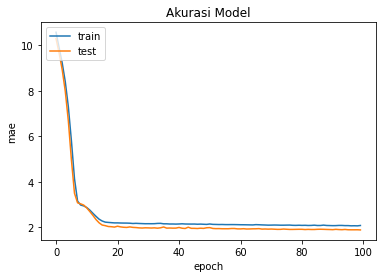

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

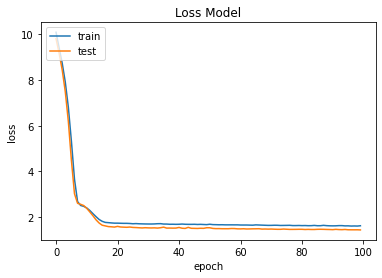

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()